# 4. Übungsblatt: MNIST mit Pytorch
Verschaffen Sie sich zunächst einen Überblick der Ordner-Strucktur. In dem Hauptordner sollten die drei Ordner:
*   `train`
*   `val`
*   `test`


enthalten sein. Jeder dieser Ordner enthält 10 Unterordner, mit den Namen 0, 1, ..., 9. In jedem dieser Ordner sind Graustufen-Bilder im png-Format enthalten.

## 1. Daten einlesen
Zunächst definieren wir den Pfad zum Hauptordner.

In [6]:
# Um Klassendefinition auf mehrere Zellen aufteilen zu können.
# !{sys.executable} -m pip install jdc
import jdc
import os
import sys

root_dir = os.path.abspath(".") + os.sep + "MNIST_IMG" + os.sep # os.getcwd() + os.sep + "MNIST_IMG" + os.sep

#### Seeds setzen (optional)
Die Gewichte der Modelle werden in der Regel zufällig belegt, außerdem werden die Samples im Dataloader oft gemischt. Somit entsteht sehr viel Zufall, sodass die Ergebnisse mit gleichen Hyperparametern stark abweichen können. Damit die Ergebnisse reproduzierbar sind, setzen wir entsprechende Seeds und deterministic-flags.

In [7]:
import numpy as np
import random
import torch

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## 2. Dataloader
Erstellen Sie nun eine Subclass der Klasse Dataset von `torch.utils.data`. Dazu müssen Sie die folgenden drei Methoden überschreiben:

*   `__init__(self)` Den Konstruktor kennen Sie bereit aus vorherigen Übungsblättern. Diesem können Sie noch weitere Parameter übergeben.
*   `__len__(self)` Diese Methode soll eine natürliche Zahl zurück geben, die der Größe des Datensatzes entspricht.
*   `__getitem__(self, idx)` Der Parameter `idx` spezifiziert das Sample das geladen werden soll.

Tipps und Hinweise:
1. Es könnte nützlich sein, dem Konstruktor zwei weitere Parameter zu übergeben, z.B. `root_dir` und `loader_mode`. `root_dir` wäre der Wert aus der Zelle zuvor und kann im Konstruktor genutzt werden um die Pfade der Bilder in einer Liste oder einem Array zu speichern. `loader_mode` könnte ein String wie z.B. "train", "val" oder "test" sein. Das kann sinnvoll sein, wenn wir für den Dataloader der für das Training verwendet wird, die Daten anders laden soll als z.B. der Dataloader für die Validierung oder den Test.
2. Im Allgemeinen werden im Konstruktor lediglich die Pfade, jedoch nicht die Bilder selbst geladen. Das liegt daran, dass moderne Datensätze sehr groß sind. Wenn Sie dann alle Bilder laden würden, kann es schnell passieren, dass Ihr Arbeitsspeicher überläuft.
3. Angenommen Ihr Dataloader soll die Trainingsbilder laden. Wenn Sie im Konstruktor eine Liste oder Array, aller Trainingsbilder erstellen, dann muss `__len__(self)` lediglich die Länge dieser Liste zurückgeben.
4. Beachten Sie, dass unser Modell ein Multilayer Perzeptron ist, das heißt `__getitem__(self, idx)` muss zunächt das Bild laden und dann in einen Vektor der Größe 784 = Länge (28) * Breite (28) des Bildes transformieren. Hierfür können Sie die Zeilen einfach hintereinander schreiben und ggf. transponieren.
5. Beachten Sie, dass Sie das geladene Bild (je nach verwendetem Package ein numpy-Array oder ein anderes Objekt) in ein Pytorch Tensor konvertieren müssen.
6. Denken Sie daran, dass `__getitem__(self, idx)` nicht nur das Bild, sondern auch das Label des Bildes zurückgeben muss.


Oftmals ist der Dataloader komplizierter als das Training des Modells. Das Training läuft oft nach dem gleichen Schema ab, wenn sich jedoch die Daten oder das zu verwendete Modell ändert, dann ändert sich meistens auch der Dataloader.

In [8]:
import glob
import torch
import torchvision
import cv2
from tqdm import tqdm
from torch.utils.data import Dataset

def list_subdirs(path):
    ps = []
    for file in os.listdir(path):
        if os.path.isdir(os.path.join(path, file)):
            ps += [file]
    return ps

def list_files(path):
    ps = []
    for file in os.listdir(path):
        if not os.path.isdir(os.path.join(path, file)):
            ps += [file]
    return ps

class Simple_Dataloader(Dataset):
    def __init__(self, root_dir, loader_mode):
        print(loader_mode)
        self.root_dir = root_dir
        self.loader_mode = loader_mode

        if not loader_mode in ["train", "val", "test"]:
            raise Exception
        
        self.root_dir += self.loader_mode + os.sep
        print(self.root_dir)

        self.imgs = []
        self.c = []

        for c in list_subdirs(self.root_dir):
            # print(c)
            # self.data[c] = []
            for f in list_files(self.root_dir + c + os.sep):
                self.imgs += [f]
                self.c += [c]

        self.imgs, self.c = zip(*sorted(zip(self.imgs, self.c)))
        # print(self.data)
        
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        lbl = self.c[idx]

        img_path = self.root_dir + lbl + os.sep + self.imgs[idx]
        
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # Transform Numpy Array into Pytorch Tensor
        img_torch = self.transform(img)
        
        # Flatten Tensor
        img_flattened = torch.flatten(img_torch)

        return img_flattened, int(lbl)

loader = Simple_Dataloader(root_dir, "test")
# print(loader[0])


test
c:\Users\tobia\Documents\Git-Repositories\ki\U04\MNIST_IMG\test\


## 3. Von Dataset zu Dataloader
Zuvor haben wir eine Subclass der Klasse Dataset erstellt. Damit ist klar, wie die Daten geladen und vorbereitet werden. In modernen Frameworks wie Pytorch, Tensorflow und Keras werden einzelne Sampels (in unserem Fall also Bilder) zu einer so genannten `Batch` gruppiert. Die Größe der Batch hängt in der Regel vom vorhandenen VRAM oder im Falle eines Trainings mit CPU vom Arbeitsspeicher ab. Oft werden Batchgrößen zwischen 8 und 128 verwendet. Bei einer Batch von 1, redet man oft auch von einer Mini-Batch. Das Trainieren mit einer Mini-Batch ist selten effektiv, da die Gewichte nach jedem Sample angepasst werden und dies die Konvergenz behindern kann. Wäre die Batch so groß wie der ganze Datensatz, dann wäre zwar das Modell perfekt auf unsere Trainingsdaten angepasst, aber möglicherweise die generallisierung nicht so gut, wie wenn eine kleinere Batch gewählt worden wäre. Daher wählt man auch bei sehr guter Hardware, selten eine Batch die größer ist als 512. Da die MNIST Bilder sehr klein sind, sollte eine Batch zwischen 32 und 128 machbar sein.

In [9]:
batch_size_train = 16 # 8
batch_size_val = 1

seed_everything(1)

print("Cache Data:")

train_dataset = Simple_Dataloader(root_dir=root_dir, loader_mode="train")
val_dataset = Simple_Dataloader(root_dir=root_dir, loader_mode="val")
test_dataset = Simple_Dataloader(root_dir=root_dir, loader_mode="test")


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, pin_memory=True,
                                               shuffle=True, drop_last=False)

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size_val, pin_memory=True,
                                             shuffle=False, drop_last=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, pin_memory=True,
                                              shuffle=False, drop_last=False)

dataset_sizes = dict()
dataset_sizes["train"] = len(train_dataset)
dataset_sizes["val"] = len(val_dataset)
dataset_sizes["test"] = len(test_dataset)
dataset_sizes

Cache Data:
train
c:\Users\tobia\Documents\Git-Repositories\ki\U04\MNIST_IMG\train\
val
c:\Users\tobia\Documents\Git-Repositories\ki\U04\MNIST_IMG\val\
test
c:\Users\tobia\Documents\Git-Repositories\ki\U04\MNIST_IMG\test\


{'train': 42152, 'val': 17848, 'test': 10000}

## 4. Definition des Modells
Jetzt sind wir bereit unser erstes MLP zu definieren. Betrachten wir hierzu folgende Modell-Vorlage:
```
input_layer = nn.Linear(784, 128)
hidden1 = nn.Linear(128, 64)
output_layer = nn.Linear(64, 10)
```
In dieser Aufgabe betrachten wir nur Fully-Connected Layers. Das sind Layer, in denen jedes Neuron des i-ten Layers mit jedem Neuron des (i+1)-ten Layers verbunden sind. In Pytorch verwendet man hierfür `nn.Linear(in_features, out_features)`. Da all unsere 28 x 28 Bilder zuvor zu einem Vektor mit 784 Einträgen konvertiert wurden, ist `in_features` im `input_layer` 784. Eine andere Zahl, die sich in dieser Aufgabe ebenfalls nicht ändert, ist die Anzahl der Klassen: Wir betrachten ausschließlich Bilder die Zahlen zwischen 0 und 9 zeigen. Daher hat der Parameter `out_features` im Layer `output_layer` den Wert 10. Für alle andere Zahlen gilt: Die Anzahl der `out_features` im Layer i, muss exakt mit der Anzahl der `in_features` im Layer i+1 übereinstimmen.

Als nächstes betrachten wir die `forward(self, x)` Methode.
```
def forward(self, x):
    x1 = torch.nn.functional.relu(self.input_layer(x))
    x2 = torch.nn.functional.relu(self.hidden1(x1))
    x_out = torch.nn.functional.relu(self.output_layer(x2))
    return x_out
```
Bisher ist noch nicht klar in welcher Reihenfolge die zuvor definierten Layer angewendet werden und wir haben uns noch keine Gedanken um die Aktivierungsfunktionen gemacht. Wenn das Modell auf eine Eingabe angewendet wird, dann wird diese Methode aufgerufen, dabei ist `x` die Eingabe, also unser Vektor mit 784 Einträgen. In diesem Beispiel wird die Eingabe `x` zunächst auf den Layer `input_layer` angewendet und auf jedes der `out_features = 128` Neuronen wird die Aktivierungsfunktion `ReLu` angewendet. Dieses Zwischenergebnis speichern wir in der Variable `x1`. Nun nehmen wir dieses Zwischenergebnis (ein Vektor mit 128 Einträgen) und wenden den Layer `hidden1` darauf an und anschließend wenden wir wieder die Aktivierungsfunktion `ReLu` an. Das gleiche geschieht jetzt noch ein drittes Mal, bevor x_out (also ein Vektor mit 10 Einträgen) zurückgegeben wird. Da wir auch beim dritten Mal `ReLu` auf alle Ausgabeneuronen angewendet haben, liegt jeder Wert in `x_out im Bereich` $[0, \infty[$


Definieren Sie ihr eigenes Modell, mit mindestens drei Hidden-Layern. Nach dem Training, sollte Ihr Modell mindestens einen F1-Score von 80% erreichen.



* [Hier](https://pytorch.org/docs/stable/nn.functional.html#non-linear-activation-functions) finden Sie eine Auswahl weiterer Aktivierungsfunktionen.
* Tipp für Interessierte: Anstatt die Ausgabewerte nur von Layer i zu Layer i+1 und von dort zu Layer i+2 weiterzugeben, können sogenannte Skip-Connections verwendet werden. Damit werden zusätzlich zum normalen Verlauf noch die Informationen von Layer i direkt zu Layer i+2 gesendet. Somit bekommt Layer i+2 die Informationen von Layer i+1 und die von Layer i. Es gibt nun mehrere Möglichkeiten, wie wir mit diesen Zusatzinformationen umgehen können. Der klassische Ansatz ist der, dass Layer i und i+1 die gleiche Anzahl `n` Ausgabeneuronen haben und Layer i+2 eben genau `n` Eingabeneuronen besitzt. Dann werden die Ausgaben (inkl. Aktivierungsfunktion) von Layer i und i+1 addiert und als Eingabe für Layer i+2 verwendet. Es ist aber auch denkbar, dass beide Ausgaben konkateniert werden, dann muss Layer i+2 im Konstruktor entsprechend groß gewählt werden. Beispiel für Konkatenation: Wenn Layer i 128 Ausgabeneuronen und Layer (i+1) 64 Ausgabeneuronen hat, dann müsste Layer i+2 192 Eingabeneuronen haben. Durch diesen Trick können Ihre Ergebnisse deutlich verbessert werden.

In [10]:
import torch.nn as nn
import torch.nn.functional as F

num_epochs = 15

class Our_first_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.input_layer = nn.Linear(784, 64)
        self.hidden1 = nn.Linear(64, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.hidden3 = nn.Linear(128, 32)
        self.output_layer = nn.Linear(32, 10)

        
    def forward(self, x):
        x = F.relu(self.input_layer(x))
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = F.relu(self.output_layer(x))
        return x

## 5. Fehlerfunktion und Hyperparameter definieren
Erstellen Sie zunächst eine Instanz Ihres Modells mit dem Namen `model`. Wenn Sie eine Grafikkarte verwenden, können Sie mit `model.to(device)` ihr Modell in den VRAM laden um später das Training zu beschleunigen. Wenn Sie das machen, müssen Sie aber später im Training darauf achten, dass Ihre Eingabedaten und Labels ebenfalls in die Grafikkarte geladen werden. Das können Sie ebenfalls mit `.to(device)` machen.


Als Optimierer, kennen Sie aus der Vorlesung bereits den _Gradient Descent_. Wir benötigen den Optimier später im Training um die Gewichte so anzupassen, dass der Fehler minimiert wird. Da wir - wie oben beschrieben - unsere Gewichte nicht für alle Samples auf einmal anpassen (da batch size < Anzahl Samples im Datensatz) verwenden wir den _Stochastic Gradient Descent (SGD)_. Es gibt aber auch "verbesserte" Ansätze wie z.B. Adam. 

Pro-Tipp (nicht prüfungsrelevant):
Ein Problem bei SGD ist, dass die Lernrate eine "globale Lernrate" ist und somit für alle Richtungen gleich bleibt. Bei mehrdimensionalen Funktionen kann das aber zum Problem werden. Denn wenn Ihre aktuellen Gewichte eine Position auf der mehrdimensionalen Funktion beschreiben, die in einer Dimension ein Plateau ist und in einer anderen Richtung eine sehr starke Steigung hat, dann würde SGD in der Richtung des Plateaus sich kaum bewegen und in der Richtung der starken Steigung einen sehr großen Sprung machen. Um das zu verhindern führt Adam eine adaptive Lernrate für jede Richtung/Dimension ein ein. Diese sorgt dafür, dass in Richtungen eines Plateaus größere Sprünge gemacht werden als in Richtungen mit starken Steigungen. Adam hat sich daher als sehr effektiv herausgestellt und konvergiert viel schneller als SGD. Das ist allerdings keine Garantie dafür, dass das Minimum in dem Adam landet auch stets besser ist als das mit SGD.

Als Hyperparameter betrachten wir aktuell nur die Lernrate `cur_lr`. Weitere Parameter hängen zum Teil auch von dem verwendeten Optimierer ab. [Hier](https://pytorch.org/docs/stable/optim.html#algorithms) finden Sie eine Übersicht möglicher Optimierer und ihrer Parameter.

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

model = Our_first_MLP()
model = model.to(device)

cur_lr = 0.1



optimizer = torch.optim.SGD(model.parameters(), lr=cur_lr)
# optimizer = torch.optim.Adam(model.parameters(), lr=cur_lr)

# Define a reasonable Loss function
criterion = nn.CrossEntropyLoss()

cpu


## 6. Training und Validierung implementieren
Jetzt sollen Sie das Training und die Validierung implementieren. Um den Aufbau besser erklären zu können führen wir zunächst drei neue Wörter ein:

1. Epoche: Eine Epoche beschreibt eine vollständige Trainings- und Validierungsphase.
2. Phase: Es gibt die Trainings- und die Validierungsphase. Die Validierungsphase folgt immer nach der Trainingsphase.
3. Iteration: Zuvor haben wir schon über eine Batch geredet. Der Dataloader läd also eine Batch und die zugehörigen Labels. Bei einer Datensatzgröße von $n$ Samples, entstehen $\big \lfloor\frac{n}{\text{batch size}} \big  \rfloor$ Batches. In jeder Phase iterieren wir über alle Batches. Einen dieser Schleifendurchläufe nennen wir Iteration.

Bei der Implementierung können sich an folgender Struktur orientieren:
1. Zunächt benötigen wir eine Schleife die über alle Epochen läuft, also von 1 bis `num_epochs`.
2. Die Phasen können direkt hintereinander implementiert werden oder als Schleife mit zwei Durchläufen, einmal für die Trainingsphase und einmal für die Validierungsphase. Das hintereinander Schreiben ist für viele (Anfänger) intuitiver.
   2.1. In der Trainingsphase setzen wir das Modell auf trainieren und verwenden hierfür: `model.train()`  
   2.2. In der Validierungsphase setzen wir das Modell auf evaluieren und verwenden hierfür: `model.eval()` 
3. Für die Iterationen benötigen wir wieder eine Schleife, z.B. von der Form: `for inputs, labels in train_dataloader:`  
   3.1. Wenn Sie für das Training eine Grafikkarte verwenden und zuvor das Modell in die Grafikkarte geladen haben, dann müssen Sie auch ihre Eingaben und label auf die Grafikkarte laden. Das können Sie so machen: `inputs = inputs.to(device)`
4. Gewichte werden nur in der Trainingsphase angepasst, nicht in der Valdierungsphase.
5. In jeder Iteration sollten Sie mit `optimizer.zero_grad()` die Gradienten zurück auf 0 setzen. Ohne zu sehr ins Detail zu gehen: `optimizer.zero_grad()` muss nicht zwingend in jeder Iteration zurückgesetzt werden, ist für uns aber einfacher.
6. Um das Training nicht unnötig zu verlangsamen, sollten wir Pytorch mitteilen, wann wir uns in der Trainingsphase befinden. Dies können wir mit  
`with torch.set_grad_enabled(phase == 'train'):`  
   machen. Dadurch weiß Pytorch ob im Loss die Graidenten berechnet werden müssen oder nicht. In der Validierungsphase werden wir die Gewichte nicht anpassen, daher benötigen wir auch keine Gradientenberechnung.
7. Direkt danach, können wir mittles `outputs = model(inputs)` die Modellausgabe für unsere Batch `inputs` berechnen.
8. Anschließend berechnen wir den Fehler zwischen der Modellausgabe und der erwarteten Ausgabe (dem Ground Truth): `loss = criterion(outputs, labels)`.
9. Bevor wir den `with torch.set_grad_enabled(phase == 'train'):` Block verlassen, müssen wir mittels `loss.backward()` den Fehler zu allen Gewichten zurückpropagieren und anschließend mit Hilfe von `optimizer.step()` die Gewichte aktualisieren.
10. Damit wir erkennen ob unser Modell overfitted, berechnen wir ein Trainingsloss und ein Validierungsloss.

Hinweise:  
Auf der Pytorch Website finden Sie einige gute Beispiele und Tutorials.  
* [Hier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#train-the-network) finden Sie z.B. ein Beispiel für ein Training und weiter unten wird auch auf die Testfunktion eingegangen.


In [12]:
import sys
from tqdm import tqdm

def train_model(train_dataloader, val_dataloader):
    for e in range(1, num_epochs + 1):
        model.train()
        ##########
        # training
        ##########
        i = 0
        for inputs, labels in train_dataloader:
            i += 1
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        
        print(f"Epoche: {e}")

        #############
        # validierung
        #############
        # model.eval()
        # for inputs, labels in val_dataloader:
        #     inputs.to(device)



### 6.1. Training durchführen
Führen Sie die Trainingsmethode aus.

In [13]:
train_model(train_dataloader, val_dataloader)


Epoche: 1
Epoche: 2
Epoche: 3
Epoche: 4
Epoche: 5
Epoche: 6
Epoche: 7
Epoche: 8
Epoche: 9
Epoche: 10
Epoche: 11
Epoche: 12
Epoche: 13
Epoche: 14
Epoche: 15


## 7. Evaluierung
### 7.1. Metriken berechnen
Implementieren Sie eine Funktion, die die Precision, Recall und F1-Score für eine gegebene Confusion Matrix berechnet.

In [14]:
from sklearn import metrics

def eval(predicted, actually):
    # print(metrics.confusion_matrix(actually, predicted))
    precission  = metrics.precision_score(actually, predicted, average="macro", zero_division=1)
    recall      = metrics.recall_score(actually, predicted, average="macro", zero_division=1)
    f1          = metrics.f1_score(actually, predicted, average="macro", zero_division=1)
    return (precission, recall, f1)

### 7.2. Test-Funktion implementieren
Implementieren Sie nun die Test Funktion. Das Vorgehen ist ähnlich zur Validierungsphase, mit dem Unterschied, dass sie kein Loss berechnen sollen, sondern die klassifizierten Ergebnisse in eine Confusion-Matrix eintragen. Nachdem alle Samples klassifiziert und in der Confusion Matrix gespeichert wurden, soll die Confusion Matrix an die obige Funktion zur Berechung der Precision, Recall und F1-Score übergeben werden.

In [15]:
def test_model(test_dataset, save_data=True):
    
    model.eval()
    pred_true = 0

    actually = []
    predicted = []
    
    for inputs, labels in test_dataset:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        # print(outputs)
        tmp = 0
        pred = 0
        for i, t in enumerate(outputs[0]):
            if tmp < t:
                tmp = t
                pred = i
                
        
        actually += [int(labels)]
        predicted += [int(pred)]        
    
    return (predicted, actually)

(predicted, actually) = test_model(test_dataloader)
# print(predicted, actually)

### 7.3. Test durchführen
Führen Sie den Test aus und geben Sie die Precision, Recall und F1-Score aus.

In [16]:
# ToDo
(precision, recall, f1) = eval(predicted, actually)
print(f"Precision:  {precision}")
print(f"Recall:     {recall}")
print(f"F1-Score:   {f1}")


Precision:  0.9726630026750411
Recall:     0.9724278526898813
F1-Score:   0.9724801370020142


## 8. Visualisieren der Ergebnisse
Visualisieren Sie die Confusion Matrix.

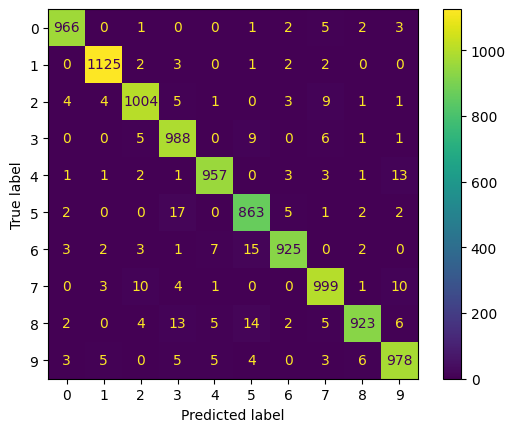

In [17]:
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(actually, predicted)
display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [0,1,2,3,4,5,6,7,8,9])
display.plot()
plt.show()



In [18]:
import winsound

winsound.Beep(2093, 180)
winsound.Beep(2093, 180)
winsound.Beep(2093, 180)
winsound.Beep(2093, 180)